In [1]:
# FINAL PROJECT - Surface Temperature and Tornado Acivity in the U.S 

In [2]:
# We will need to import necessary lib and tool
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# load in the NCEI data for Monthly average temperature
#"https://www.ncei.noaa.gov/thredds/catalog/data-in-development/nclimgrid/catalog.html?dataset=data-in-development/nclimgrid/nclimgrid_tavg.nc"
ds_1 = xr.open_dataset('surf_temp/nclimgrid_tavg.nc') 
ds_1 

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 1570, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 13kB 1895-01-01 1895-02-01 ... 2025-10-01
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    tavg     (time, lat, lon) float32 5GB ...
Attributes: (12/14)
    date_created:              2025-01-07 13:14:21.839853
    date_modified:             2025-01-07 13:14:21.840002
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

In [4]:
# Since we dont need the whole dataset, we will create a subset
# slice the dataset to keep 01/01/2000 - 12/31/2024 Monthly average temperature
#ds_1['tavg']
ds_surf_temp = ds_1.sel(time=slice("2000-01-01", "2024-12-31"))
ds_surf_temp

<xarray.Dataset> Size: 991MB
Dimensions:  (time: 300, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    tavg     (time, lat, lon) float32 991MB ...
Attributes: (12/14)
    date_created:              2025-01-07 13:14:21.839853
    date_modified:             2025-01-07 13:14:21.840002
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

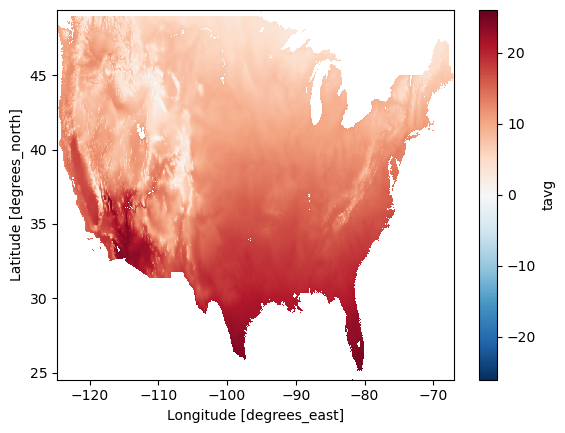

In [5]:
# Test tavg value to see if it exsist 
ds_surf_temp['tavg'].mean(dim="time").plot()

In [6]:
# next we need to mask out values that are not relevant, in this case, any coordinate outside of CONUS, and save them as zero(s)
ds_surf_temp_filtered = ds_surf_temp.fillna(0)

In [7]:
#using groupby to calculate the annual mean
st_annual = ds_surf_temp_filtered.groupby('time.year')
#print(ds_surf_temp)
#print(month)
st_annual_mean = st_annual.mean()
#mean['tavg'].squeeze().plot()


In [8]:
# print out our new dataset to make sure everything works
# We can see that the 'time' coordinate has changed to "year"
st_annual_mean

<xarray.Dataset> Size: 83MB
Dimensions:  (year: 25, lat: 596, lon: 1385)
Coordinates:
  * year     (year) int64 200B 2000 2001 2002 2003 2004 ... 2021 2022 2023 2024
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    tavg     (year, lat, lon) float32 83MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/14)
    date_created:              2025-01-07 13:14:21.839853
    date_modified:             2025-01-07 13:14:21.840002
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

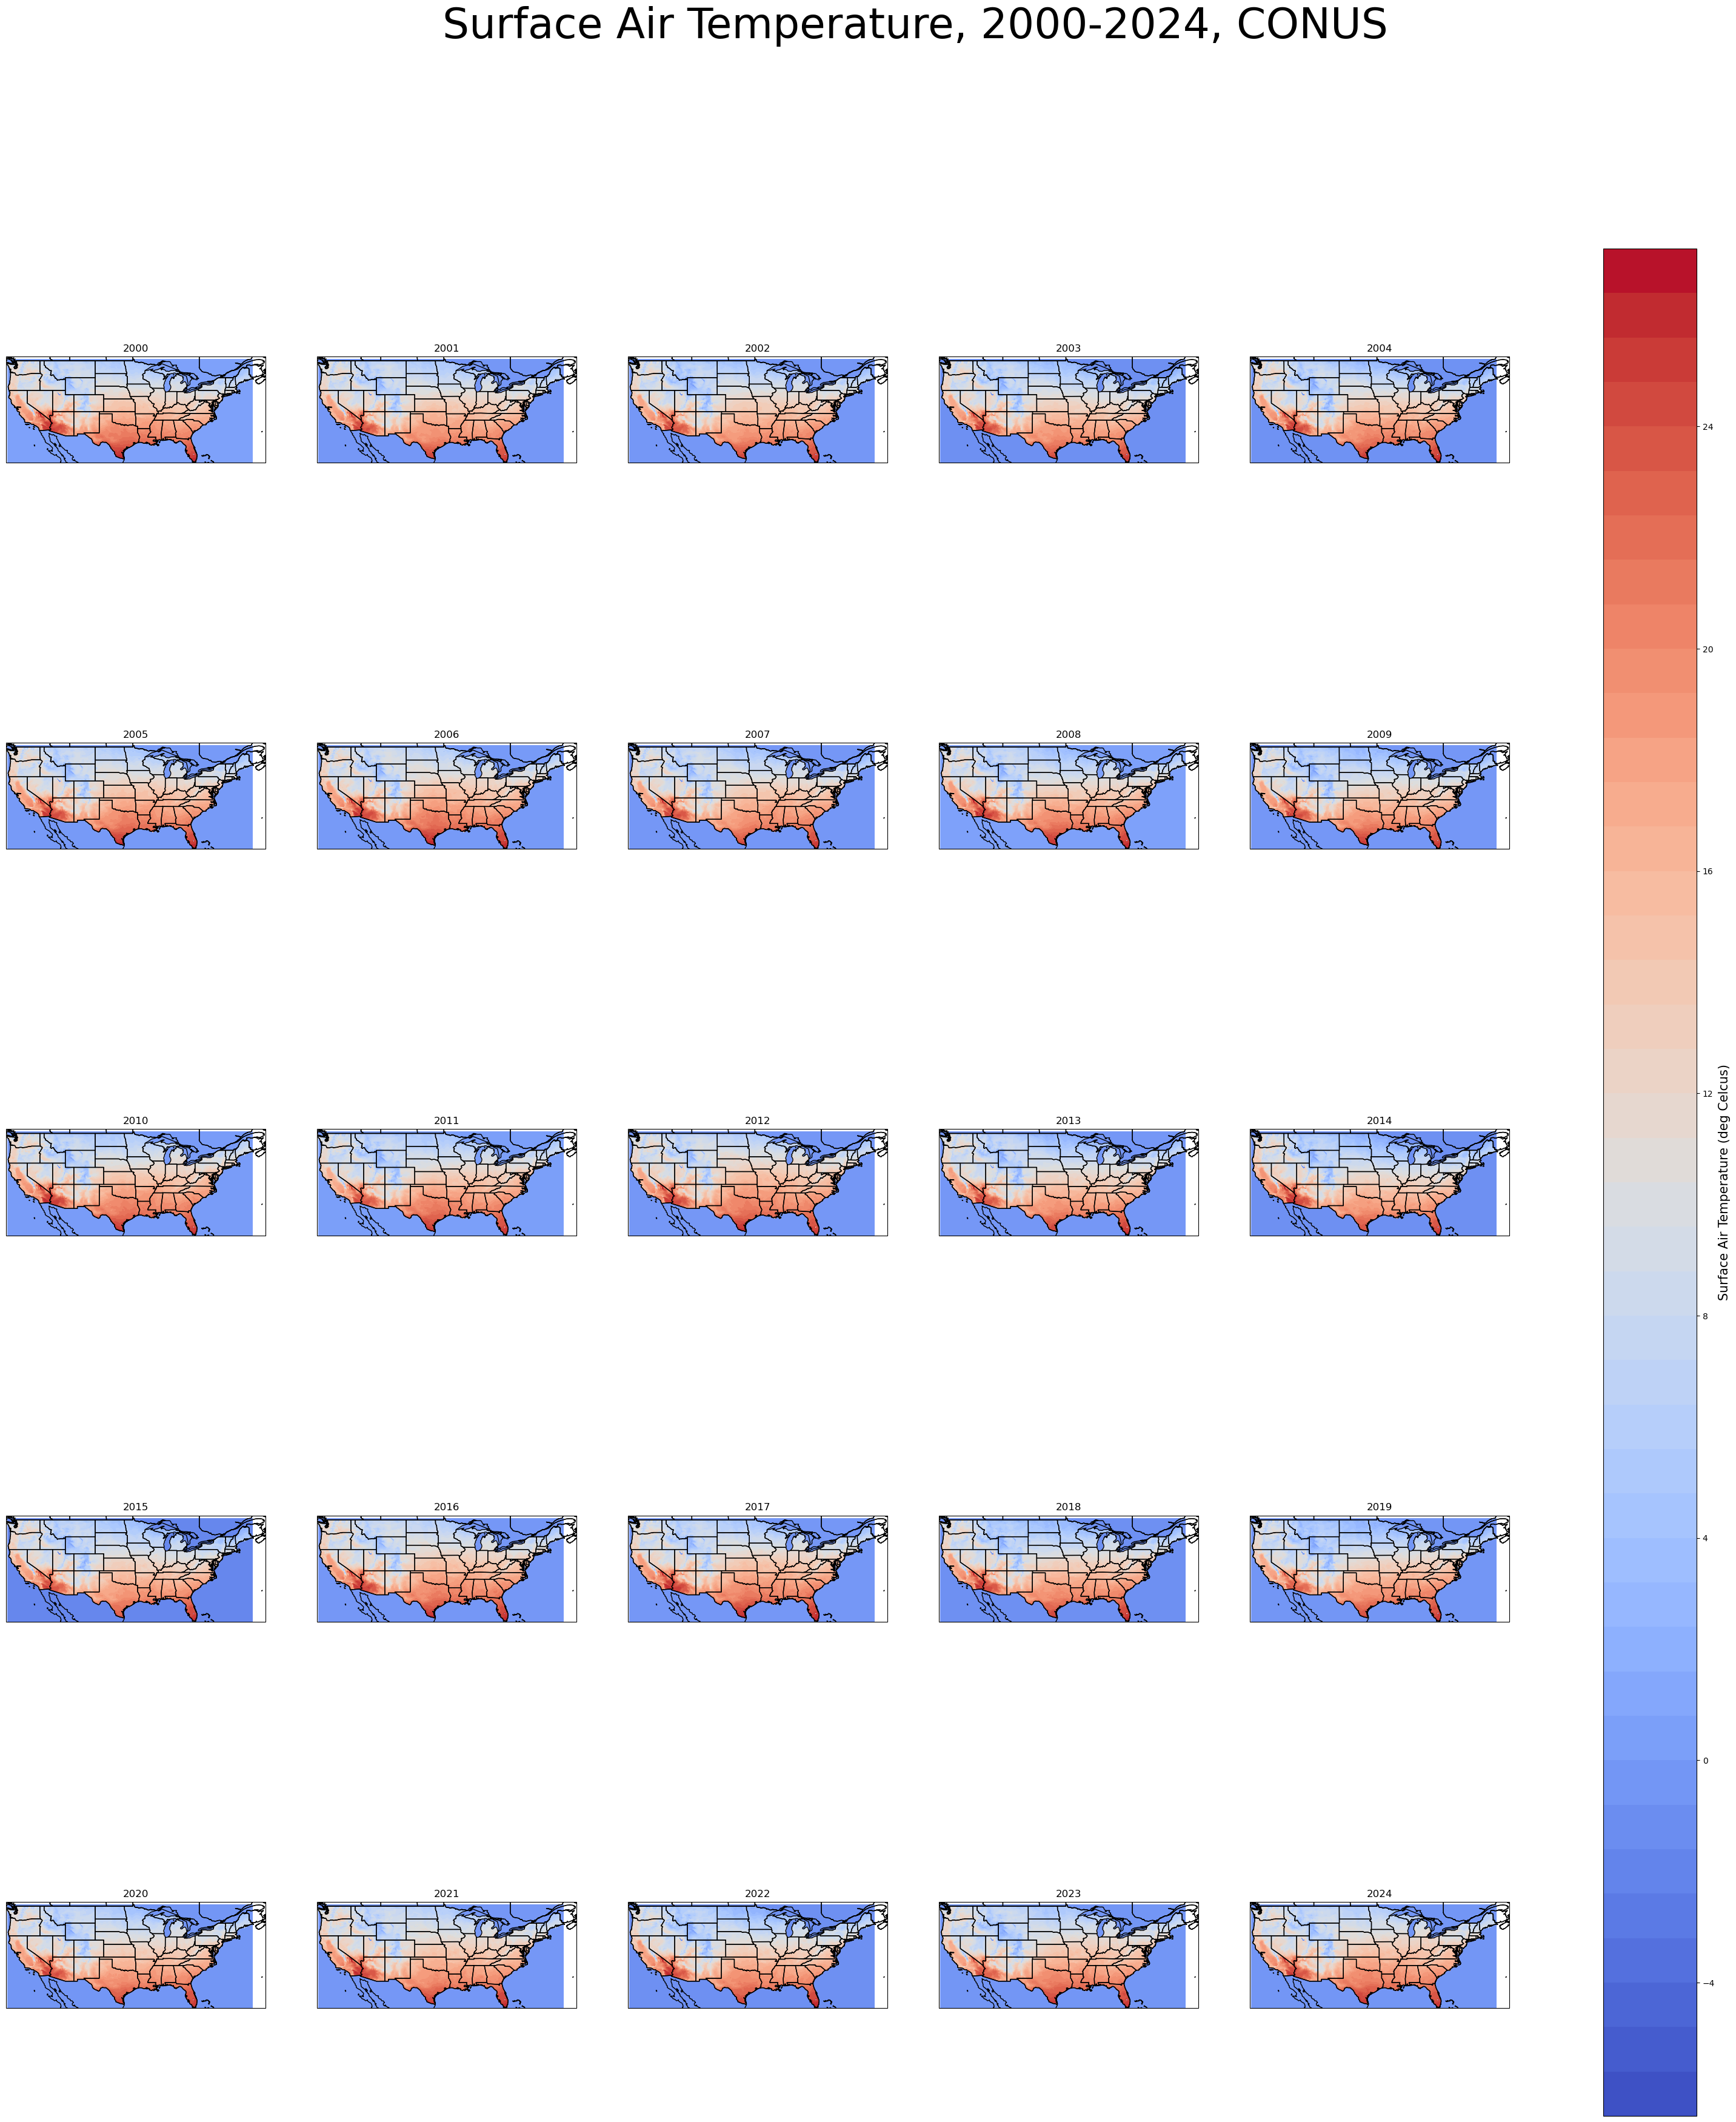

In [100]:
#create a 25 plots map for annual surf temp to see if the data are there
fig, axs = plt.subplots(nrows= 5 , ncols = 5, figsize = (40,40), subplot_kw={'projection': ccrs.PlateCarree()})

#definite Lat and Lon grid
lat = st_annual_mean["lat"]
lon = st_annual_mean["lon"]
lon2d, lat2d = np.meshgrid(lon,lat)

#flatten for easier understanding

axs= axs.flatten()

#loop through 25 years 
for i, yr in enumerate (st_annual_mean.year.values):
    data = st_annual_mean['tavg'].sel(year=yr)
    image = axs[i].contourf(lon2d, lat2d, data.values, levels=50, cmap ='coolwarm', transform =ccrs.PlateCarree())
    
    axs[i].set_title(f"{yr}")
    axs[i].add_feature(feature.COASTLINE)
    axs[i].add_feature(feature.BORDERS) #to draw borderline of the US
    axs[i].add_feature(feature.STATES) #to add Stateline 
    axs[i].set_extent([-125, -64, 25, 50], crs=ccrs.PlateCarree()) #zoom in to CONUS

# Add colorbar
cbar = fig.colorbar(image, ax= axs, orientation ='vertical')
cbar.set_label("Surface Air Temperature (deg Celcus)", fontsize = 15)
plt.suptitle("Surface Air Temperature, 2000-2024, CONUS", fontsize =50)

plt.show()

In [10]:
# Now that we have the Surface Temperature dataset done, we will load in our Tornado Dataset from FEMA
ds_2= pd.read_csv("tornado/Tornado_Tracks.csv")
ds_2

State Abbreviation Date (Year, Month, Day)      Time  EF Scale  \
0                     MO                1/3/1950  11:00:00         3   
1                     IL                1/3/1950  11:55:00         3   
2                     OH                1/3/1950  16:00:00         1   
3                     AR               1/13/1950   5:25:00         3   
4                     MO               1/25/1950  19:30:00         2   
...                  ...                     ...       ...       ...   
71808                 SC              12/29/2024   7:52:00         0   
71809                 SC              12/29/2024   7:56:00         1   
71810                 SC              12/29/2024   8:09:00         0   
71811                 NC              12/29/2024   8:21:00         0   
71812                 OH              12/29/2024  14:08:00         0   

       Starting Latitude  Starting Longitude  
0                38.7700            -90.2200  
1                39.1000            -89.3000  
2                40.8800            -84.5800  
3                34.4000            -94.3700  
4                37.6000            -90.6800  
...                  ...                 ...  
71808            34.2842            -81.1384  
71809            34.3341            -81.0875  
71810            35.1130            -81.3060  
71811            35.2010            -80.9810  
71812            40.2158            -83.4027  

[71813 rows x 6 columns]

In [11]:
#now we have the time series and need to convert this to xarray
tor = pd.DataFrame(ds_2)
ds_tor = tor.set_index(["Date (Year, Month, Day)"]).to_xarray() #set Date as the coordinate
ds_tor = ds_tor.rename({"Date (Year, Month, Day)": "Date"}) # change the coordinate name for easier usage
ds_tor["Date"] = pd.to_datetime(ds_tor["Date"])

ds_tor = ds_tor.set_coords("Starting Latitude") 
ds_tor = ds_tor.set_coords("Starting Longitude")

ds_tor 


<xarray.Dataset> Size: 3MB
Dimensions:             (Date: 71813)
Coordinates:
  * Date                (Date) datetime64[ns] 575kB 1950-01-03 ... 2024-12-29
    Starting Latitude   (Date) float64 575kB 38.77 39.1 40.88 ... 35.2 40.22
    Starting Longitude  (Date) float64 575kB -90.22 -89.3 ... -80.98 -83.4
Data variables:
    State Abbreviation  (Date) object 575kB 'MO' 'IL' 'OH' ... 'SC' 'NC' 'OH'
    Time                (Date) object 575kB '11:00:00' '11:55:00' ... '14:08:00'
    EF Scale            (Date) int64 575kB 3 3 1 3 2 2 2 2 3 ... 0 0 0 0 1 0 0 0

In [12]:
# now we slice the date to match Surface Temperate
ds_tor= ds_tor.sel(Date=slice("2000-01-01", "2024-12-31"))
#ds_tor['EF Scale'] = ds_tor['EF Scale'].fillna(0)
ds_tor

<xarray.Dataset> Size: 2MB
Dimensions:             (Date: 31298)
Coordinates:
  * Date                (Date) datetime64[ns] 250kB 2000-01-03 ... 2024-12-29
    Starting Latitude   (Date) float64 250kB 36.22 36.22 36.27 ... 35.2 40.22
    Starting Longitude  (Date) float64 250kB -92.18 -91.83 ... -80.98 -83.4
Data variables:
    State Abbreviation  (Date) object 250kB 'AR' 'AR' 'AR' ... 'SC' 'NC' 'OH'
    Time                (Date) object 250kB '6:22:00' '6:46:00' ... '14:08:00'
    EF Scale            (Date) int64 250kB 1 1 1 1 1 1 3 3 3 ... 0 0 0 0 1 0 0 0

In [13]:
# for later use, create month, year coordinates
ds_tor = ds_tor.assign_coords(
    year = ds_tor['Date'].dt.year,
    month = ds_tor['Date'].dt.month,
)
ds_tor

<xarray.Dataset> Size: 2MB
Dimensions:             (Date: 31298)
Coordinates:
  * Date                (Date) datetime64[ns] 250kB 2000-01-03 ... 2024-12-29
    Starting Latitude   (Date) float64 250kB 36.22 36.22 36.27 ... 35.2 40.22
    Starting Longitude  (Date) float64 250kB -92.18 -91.83 ... -80.98 -83.4
    year                (Date) int64 250kB 2000 2000 2000 ... 2024 2024 2024
    month               (Date) int64 250kB 1 1 1 1 1 1 1 ... 12 12 12 12 12 12
Data variables:
    State Abbreviation  (Date) object 250kB 'AR' 'AR' 'AR' ... 'SC' 'NC' 'OH'
    Time                (Date) object 250kB '6:22:00' '6:46:00' ... '14:08:00'
    EF Scale            (Date) int64 250kB 1 1 1 1 1 1 3 3 3 ... 0 0 0 0 1 0 0 0

In [14]:
# monthly tornado counts per EF scale per year - For determination of Active year later
#monthly_counts = (
#    ds_tor.groupby(['year', 'month', 'EF Scale']) #group your data based on the year, month, and EF Scale
#    .count(dim="Date") # Count the number of tornadoes
#)
#monthly_counts

#couldn't do because the EF scale values are not available for a lot of the event

In [15]:
#group them by year and month to count how many tornado happened each month - for Anomalies later
tor_monthly_count = ds_tor.groupby(['year','month']).count()
tor_monthly_count

<xarray.Dataset> Size: 7kB
Dimensions:             (year: 25, month: 12)
Coordinates:
  * year                (year) int64 200B 2000 2001 2002 2003 ... 2022 2023 2024
  * month               (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    State Abbreviation  (year, month) float64 2kB 16.0 56.0 103.0 ... 60.0 127.0
    Time                (year, month) float64 2kB 16.0 56.0 103.0 ... 60.0 127.0
    EF Scale            (year, month) float64 2kB 16.0 56.0 103.0 ... 60.0 127.0

In [16]:
#group them by year count how many tornado happened each year - for Anomalies later
tor_annual_count = ds_tor.groupby('Date.year').count()
tor_annual_count
#ds_tor

<xarray.Dataset> Size: 800B
Dimensions:             (year: 25)
Coordinates:
  * year                (year) int64 200B 2000 2001 2002 2003 ... 2022 2023 2024
Data variables:
    State Abbreviation  (year) int64 200B 1075 1215 934 1374 ... 1143 1321 1791
    Time                (year) int64 200B 1075 1215 934 1374 ... 1143 1321 1791
    EF Scale            (year) int64 200B 1075 1215 934 1374 ... 1143 1321 1791

In [17]:
#Can we do a running mean so see if Tornado activity has gone up?

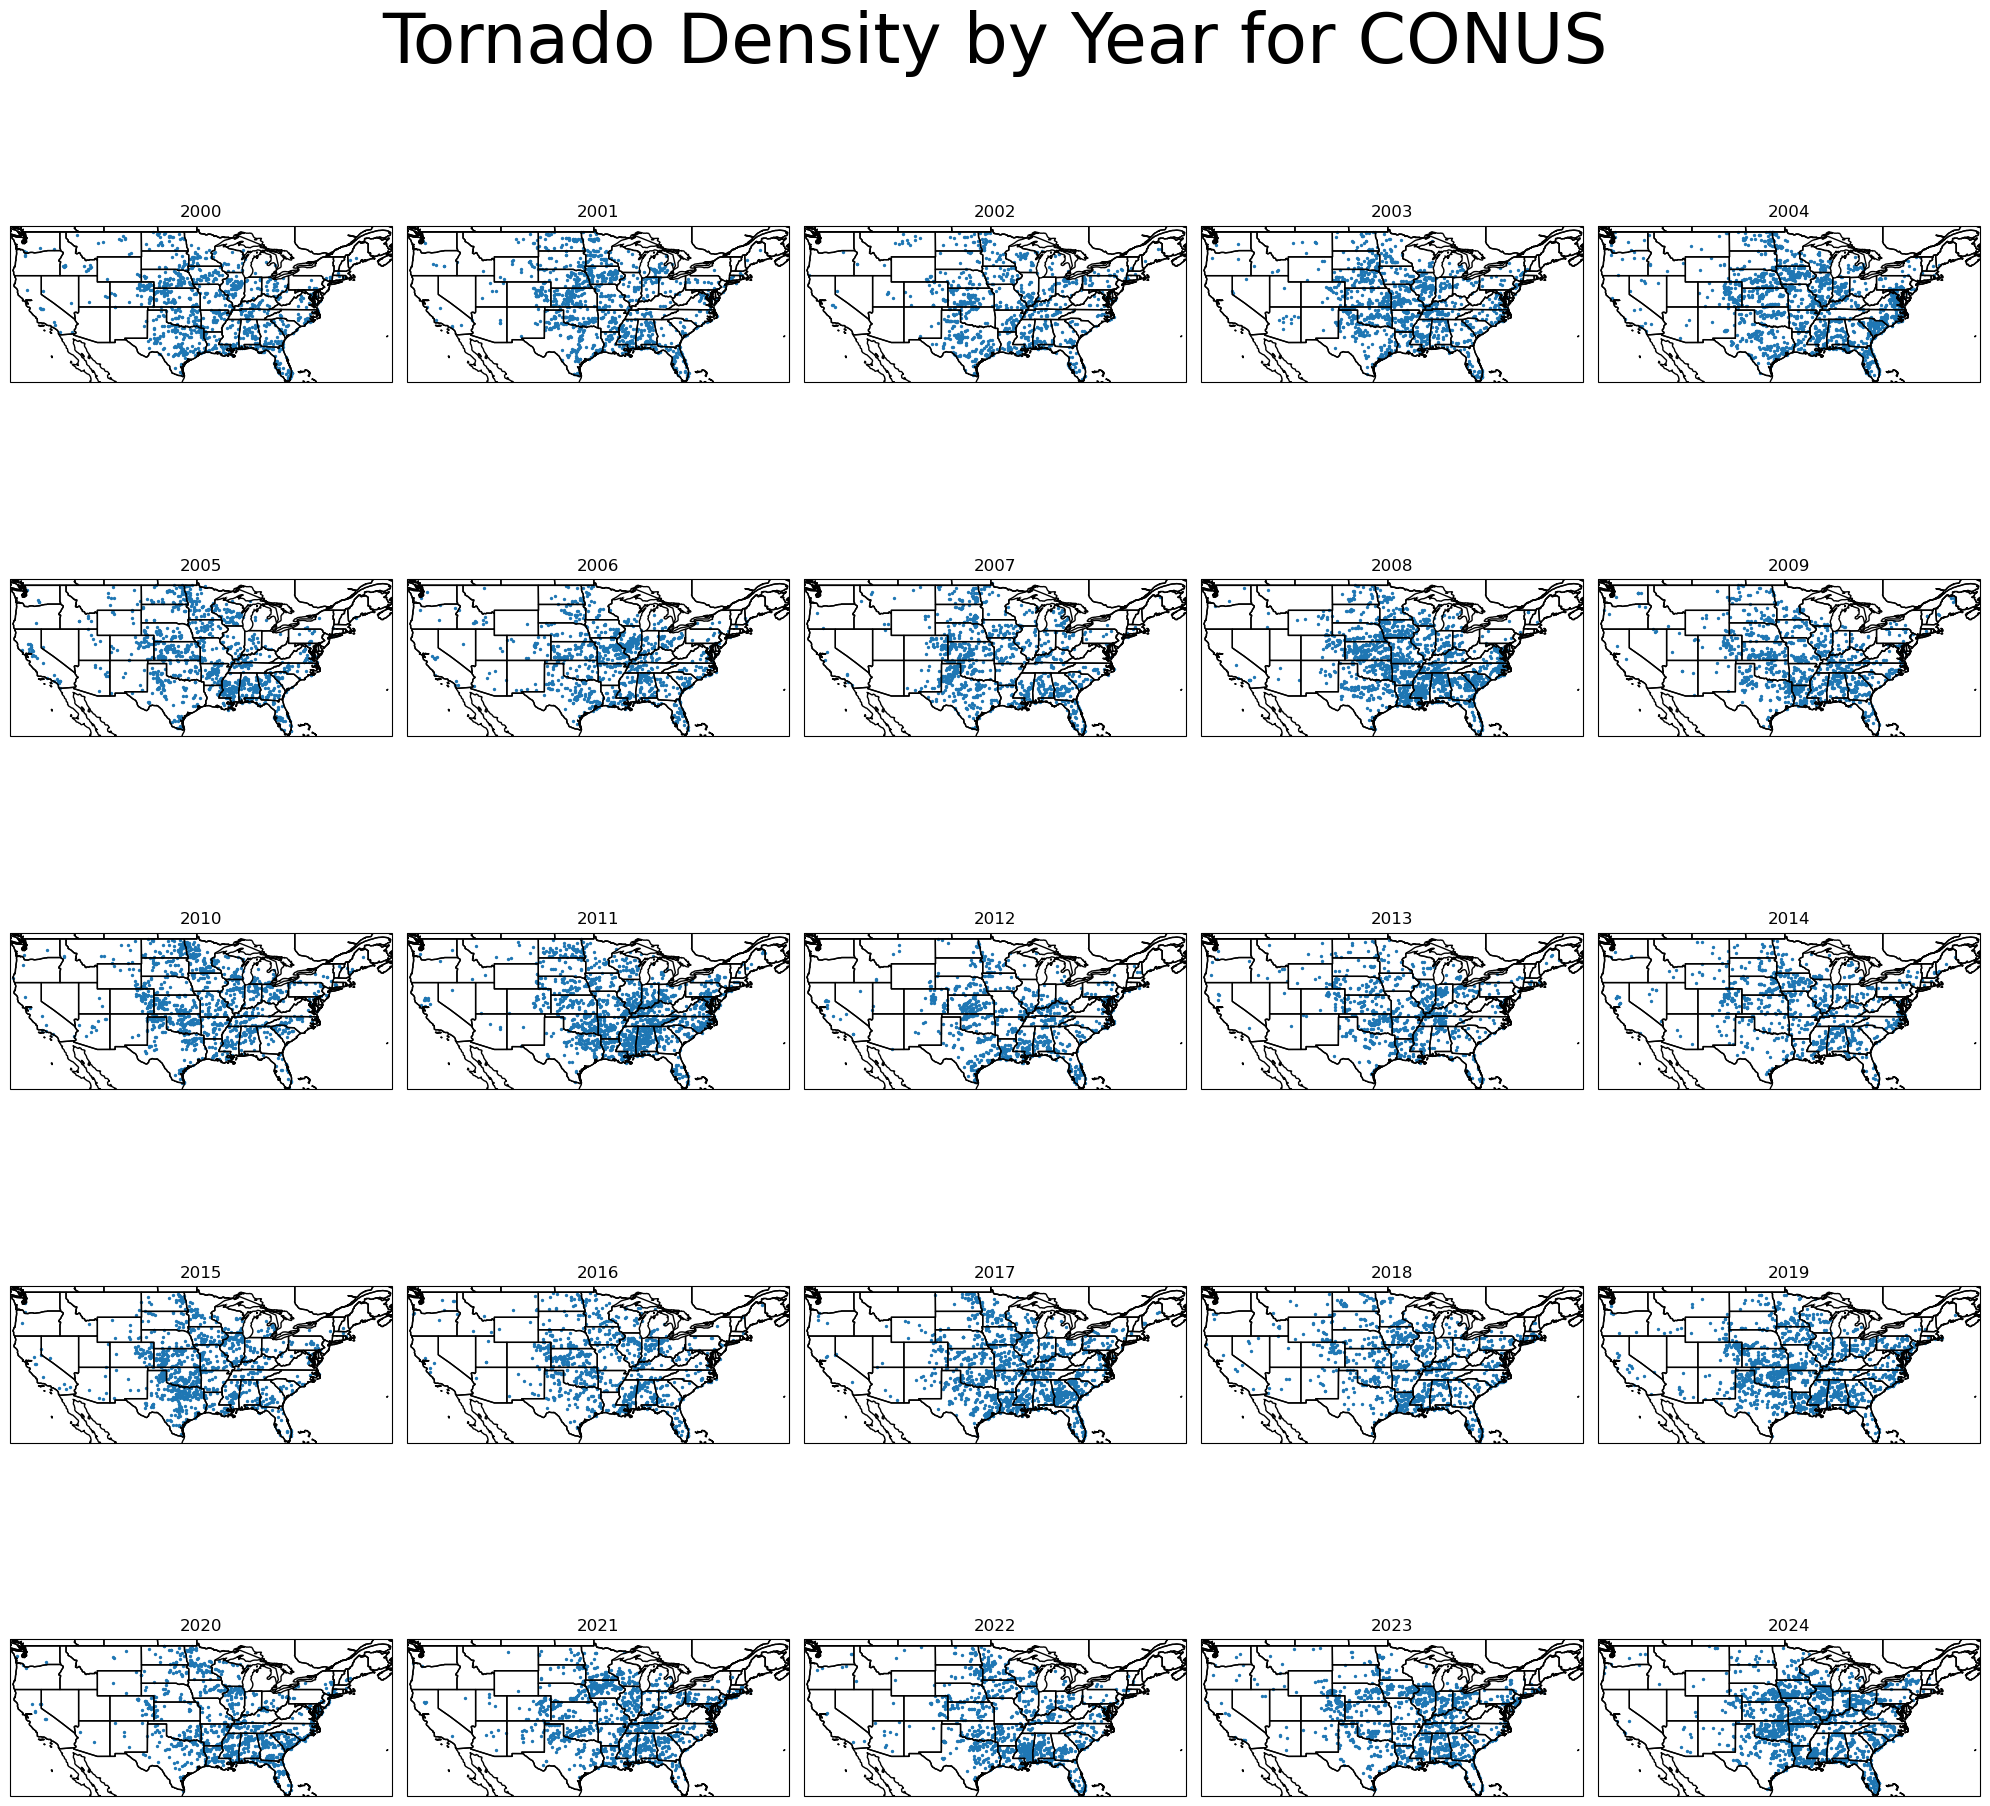

In [101]:
# Create multi-plot, one for each year to observe the variation in density
fig, axs = plt.subplots(nrows = 5, ncols = 5, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()


for i, (year, ds_year) in enumerate (ds_tor.groupby("year")):
    ax = axs[i]
    map= ax.scatter(ds_year["Starting Longitude"], ds_year["Starting Latitude"], s=2)
    
    ax.set_title(f"{year}")
    ax.add_feature(feature.COASTLINE)
    ax.add_feature(feature.BORDERS) #to draw borderline of the US
    ax.add_feature(feature.STATES) #to add Stateline 
    ax.set_extent([-125, -64, 25, 50], crs=ccrs.PlateCarree()) #zoom in to CONUS
    

plt.suptitle("Tornado Density by Year for CONUS", fontsize=50)
plt.tight_layout()
plt.show()

In [19]:
# Now that we have both of our datasets loaded and ready
## Calculate Surface Temperature anomalies to see if there is a change in Surface Temperature for the past 25 years
##  Monthly mean for each month of the year

ds_surf_temp_filtered #the orginial dataset is already a monthly mean surface temp

<xarray.Dataset> Size: 991MB
Dimensions:  (time: 300, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    tavg     (time, lat, lon) float32 991MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/14)
    date_created:              2025-01-07 13:14:21.839853
    date_modified:             2025-01-07 13:14:21.840002
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

In [20]:
# calculating the mean ST for each month - 12 months in total
st_climatology = ds_surf_temp_filtered.groupby('time.month').mean() # here, we calculate each month average for the 25 years span. For example, the average for all January, February, etc
st_climatology

<xarray.Dataset> Size: 40MB
Dimensions:  (month: 12, lat: 596, lon: 1385)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    tavg     (month, lat, lon) float32 40MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/14)
    date_created:              2025-01-07 13:14:21.839853
    date_modified:             2025-01-07 13:14:21.840002
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

In [21]:
# now we will compute the anomalies by substracting the climatology from the orginal time series for ST and Tornado
### Surface Temp
st_anoms = ds_surf_temp_filtered.groupby('time.month') - st_climatology
st_anoms

<xarray.Dataset> Size: 991MB
Dimensions:  (time: 300, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
    month    (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    tavg     (time, lat, lon) float32 991MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [22]:
#test for min and max since I saw tavg with zeros

ds_min = st_anoms['tavg'].min().item()
ds_max = st_anoms['tavg'].max().item()

print(f"tavg: {ds_min} to {ds_max}")

tavg: -14.625741958618164 to 9.669569969177246


In [23]:
# Now repeat for Tornado dataset
###calculating the montly mean number of tornado for each month throughout the 25 years - 12 months in total 


In [24]:
#recall the dataset
tor_monthly_count


<xarray.Dataset> Size: 7kB
Dimensions:             (year: 25, month: 12)
Coordinates:
  * year                (year) int64 200B 2000 2001 2002 2003 ... 2022 2023 2024
  * month               (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    State Abbreviation  (year, month) float64 2kB 16.0 56.0 103.0 ... 60.0 127.0
    Time                (year, month) float64 2kB 16.0 56.0 103.0 ... 60.0 127.0
    EF Scale            (year, month) float64 2kB 16.0 56.0 103.0 ... 60.0 127.0

In [25]:
#fix the coordinate making year and month into one coordinate
# Create a 1D array of datetimes for each year/month combination
years = tor_monthly_count['year'].values
months = tor_monthly_count['month'].values

#separate dims, use meshgrid
yy, mm = np.meshgrid(years, months, indexing='ij')  # shape (len(years), len(months))

# Flatten to 1D
time = pd.to_datetime({'year': yy.ravel(), 'month': mm.ravel(), 'day': 1})

# Assign as a new time coordinate
tor_monthly = tor_monthly_count.stack(time=('year', 'month'))
tor_monthly = tor_monthly .assign_coords(time=time)
tor_monthly

<xarray.Dataset> Size: 10kB
Dimensions:             (time: 300)
Coordinates:
  * time                (time) datetime64[ns] 2kB 2000-01-01 ... 2024-12-01
Data variables:
    State Abbreviation  (time) float64 2kB 16.0 56.0 103.0 ... 54.0 60.0 127.0
    Time                (time) float64 2kB 16.0 56.0 103.0 ... 54.0 60.0 127.0
    EF Scale            (time) float64 2kB 16.0 56.0 103.0 ... 54.0 60.0 127.0

In [26]:
#now we calculate the climatology - group data by month across all year (dim=year)
tor_climatology = tor_monthly_count.groupby('month').mean(dim='year')
tor_climatology 

<xarray.Dataset> Size: 384B
Dimensions:             (month: 12)
Coordinates:
  * month               (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    State Abbreviation  (month) float64 96B 39.83 39.56 94.84 ... 54.28 47.72
    Time                (month) float64 96B 39.83 39.56 94.84 ... 54.28 47.72
    EF Scale            (month) float64 96B 39.83 39.56 94.84 ... 54.28 47.72

In [27]:
#anomalies for tornado
tor_anoms = tor_monthly.groupby('time.month') - tor_climatology
tor_anoms

<xarray.Dataset> Size: 12kB
Dimensions:             (time: 300)
Coordinates:
  * time                (time) datetime64[ns] 2kB 2000-01-01 ... 2024-12-01
    month               (time) int64 2kB 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
Data variables:
    State Abbreviation  (time) float64 2kB -23.83 16.44 8.16 ... 5.72 79.28
    Time                (time) float64 2kB -23.83 16.44 8.16 ... 5.72 79.28
    EF Scale            (time) float64 2kB -23.83 16.44 8.16 ... 5.72 79.28

In [28]:
# now we got the anomalies!!!

In [29]:
# Let create a test set to do running mean to better visualize the change - from lecture, we learn to do 1 year and 10 years running mean
#recall the temperature anomaly dataset
#st_monthly_mean = ds_surf_temp_filtered.mean(dim=['lat','lon']) #create a smaller dataset to avoid datacras
#st_monthly_mean
st_anoms

<xarray.Dataset> Size: 991MB
Dimensions:  (time: 300, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
    month    (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    tavg     (time, lat, lon) float32 991MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [30]:
st_monthly_mean = st_anoms.mean(dim=['lat','lon']) #create a smaller dataset to avoid datacras
st_monthly_mean

<xarray.Dataset> Size: 6kB
Dimensions:  (time: 300)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
    month    (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    tavg     (time) float32 1kB 0.2322 1.451 0.7112 ... 1.244 0.4924 1.074

In [31]:
ds_test = st_monthly_mean['tavg']

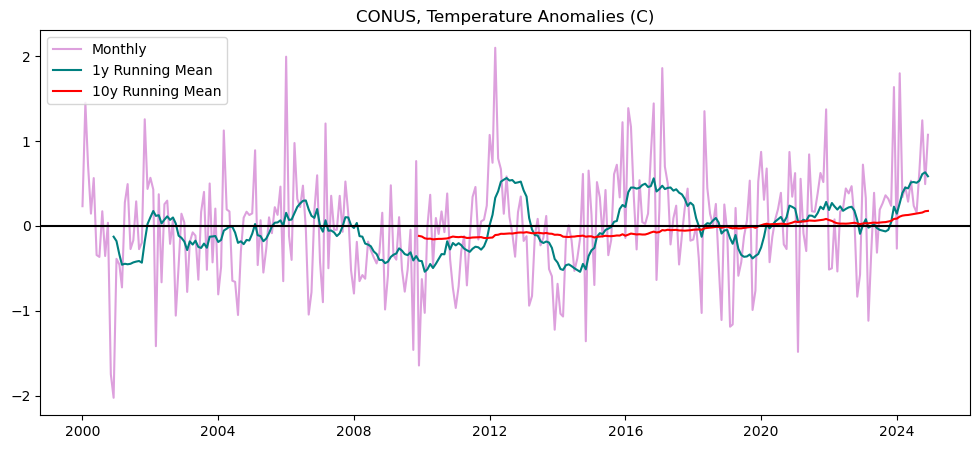

In [32]:
#plot the running mean temperature 
da_smooth_1y = ds_test.rolling(time=12).mean() #12 month = 1 year
da_smooth_10y = ds_test.rolling(time=120).mean()  #120 months = 10 years

fig = plt.figure(figsize=(12,5))
plt.plot(ds_test['time'],ds_test,label='Monthly',c='plum') #graph out the anomalies dataset
plt.plot(da_smooth_1y['time'],da_smooth_1y,label='1y Running Mean',c='teal') # graph out the 1 year mean
plt.plot(da_smooth_10y['time'],da_smooth_10y,label='10y Running Mean',c='red') # graph out the 10 years mean
plt.axhline(y=0,c='black')
plt.title('CONUS, Temperature Anomalies (C)')
plt.legend()

In [33]:
#recall Tornado Dataset
tor_anoms

<xarray.Dataset> Size: 12kB
Dimensions:             (time: 300)
Coordinates:
  * time                (time) datetime64[ns] 2kB 2000-01-01 ... 2024-12-01
    month               (time) int64 2kB 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
Data variables:
    State Abbreviation  (time) float64 2kB -23.83 16.44 8.16 ... 5.72 79.28
    Time                (time) float64 2kB -23.83 16.44 8.16 ... 5.72 79.28
    EF Scale            (time) float64 2kB -23.83 16.44 8.16 ... 5.72 79.28

In [34]:
#test for min and max 

ds_min = tor_anoms['EF Scale'].min().item()
ds_max = tor_anoms['EF Scale'].max().item()

print(f"EF Scale Range: {ds_min} to {ds_max}")

EF Scale Range: -157.04000000000002 to 559.56


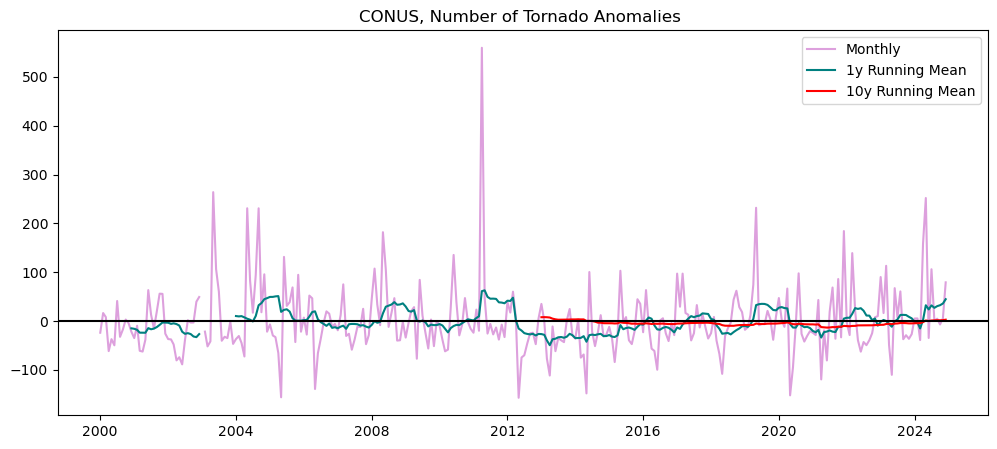

In [35]:
ds_test_2 = tor_anoms['EF Scale']
#plot the running mean number of tor 
da_smooth_1y = ds_test_2.rolling(time=12).mean() #12 month = 1 year
da_smooth_10y = ds_test_2.rolling(time=120).mean()  #120 months = 10 years

fig = plt.figure(figsize=(12,5))
plt.plot(ds_test_2['time'],ds_test_2,label='Monthly',c='plum') #graph out the anomalies dataset
plt.plot(da_smooth_1y['time'],da_smooth_1y,label='1y Running Mean',c='teal') # graph out the 1 year mean
plt.plot(da_smooth_10y['time'],da_smooth_10y,label='10y Running Mean',c='red') # graph out the 10 years mean
plt.axhline(y=0,c='black')
plt.title('CONUS, Number of Tornado Anomalies ')
plt.legend()

In [36]:
# now on to the composite - let see if there is a strong relation between surface temperature and tornado
# what are the surface temperature anomalies during Active Year and Regular Year of Tornado
### let's define 
####an Active years as having 100 more tornado than the norm
#### an inactive years as having 100 less than the norm
#### and 300 more or less than the norm as extremely active/inactive

In [37]:
#tor_active = tor_anoms["EF Scale"].where((tor_anoms['EF Scale'] >= 100) & (tor_anoms['EF Scale'] < 300))
#tor_inactive = tor_anoms["EF Scale"].where((tor_anoms['EF Scale'] <=-100) & (tor_anoms['EF Scale'] > -300))  #-100 means 100 less than the norm (norm is between -100 and 100)
#tor_normal = tor_anoms["EF Scale"].where((tor_anoms['EF Scale'] > -100) & (tor_anoms['EF Scale'] < 100))
#tor_extreme_active = tor_anoms["EF Scale"].where(tor_anoms['EF Scale'] >= 300)
#tor_extreme_inactive = tor_anoms["EF Scale"].where(tor_anoms['EF Scale'] <= -300)
#print(type(tor_active))

In [38]:
# can I turn the above into a function?
def classify_tornado_activity(count):
    #return Data array
    #Criteria:
     # - Active: 100 to 300
      #- Inactive: -100 to -300
      #- Normal: -100 to 100
      #- Extreme Active: >= 300
      #- Extreme Inactive: <= -300
    return {'Active years':count.where((count >= 100) & (count <300)),
          'Normal years':count.where((count > -100) & (count < 100)),
          'Inactive years':count.where((count <= -100) & (count >-300)),
          'Extremely Active years': count.where( count >=300),
          'Extremely Inactive years':count.where( count <=-300)
           }
#use the function
category = classify_tornado_activity(tor_anoms["EF Scale"])   
#after we did the anomalies above, Python uses each variable to count how many tornado for each month of each year so.....
tor_active = category["Active years"]
tor_inactive = category["Inactive years"]
tor_normal= category["Normal years"]
tor_extreme_active = category["Extremely Active years"]
tor_extreme_inactive = category["Extremely Inactive years"]

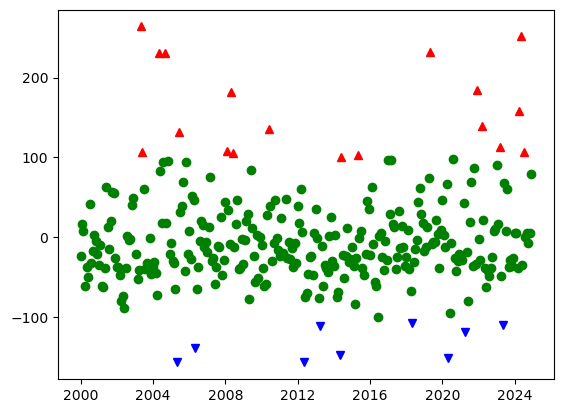

In [39]:
# test the above value
plt.plot(tor_anoms['time'],tor_active,'r^')
plt.plot(tor_anoms['time'],tor_inactive,'bv')
plt.plot(tor_anoms['time'],tor_normal,'go') 


In [40]:
# How many months do we have  for each
#print('Active years: ',tor_active.count(dim='time').values)
#print('Normal years: ',tor_normal.count(dim='time').values)
#print('Inactive year: ',tor_inactive.count(dim='time').values)
#print('Extremely Active year: ',tor_extreme_active.count(dim='time').values)
#print('Extremely Inactive year: ',tor_extreme_inactive.count(dim='time').values)


#counts={tor_active.count(dim='time').values,
#        tor_normal.count(dim='time').values,
#        tor_inactive.count(dim='time').values,
#        tor_extreme_active.count(dim='time').values,
#        tor_extreme_inactive.count(dim='time').values
#       }
counts = {'Active years':tor_active.count(dim='time').values,
          'Normal years':tor_normal.count(dim='time').values,
          'Inactive years':tor_inactive.count(dim='time').values,
          'Extremely Active years':tor_extreme_active.count(dim='time').values,
          'Extremely Inactive years':tor_extreme_inactive.count(dim='time').values
          }
print(counts)

{'Active years': array(18), 'Normal years': array(271), 'Inactive years': array(9), 'Extremely Active years': array(1), 'Extremely Inactive years': array(0)}


In [41]:
# Now we can select the dates that match Active year, Inactive year and Normal (add in Extremmely Active year and Extremely Inactive year)
#recall our surface temp anomalies dataset
st_anoms

<xarray.Dataset> Size: 991MB
Dimensions:  (time: 300, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
    month    (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    tavg     (time, lat, lon) float32 991MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [42]:
da_st = st_anoms.tavg.sel(time=slice(tor_anoms['time'][0],tor_anoms['time'][-1]))
da_st

<xarray.DataArray 'tavg' (time: 300, lat: 596, lon: 1385)> Size: 991MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
    month    (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [43]:
da_climo = da_st.groupby('time.month').mean()
da_anoms = da_st.groupby('time.month')-da_climo
da_anoms

<xarray.DataArray 'tavg' (time: 300, lat: 596, lon: 1385)> Size: 991MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
    month    (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [44]:
active_year_st = da_anoms.sel(time=tor_active.dropna(dim='time')['time']).mean(dim='time')
inactive_year_st = da_anoms.sel(time=tor_inactive.dropna(dim='time')['time']).mean(dim='time')
norm_year_st = da_anoms.sel(time=tor_normal.dropna(dim='time')['time']).mean(dim='time')
e_active_year_st = da_anoms.sel(time=tor_extreme_active.dropna(dim='time')['time']).mean(dim='time')
e_inactive_year_st = da_anoms.sel(time=tor_extreme_inactive.dropna(dim='time')['time']).mean(dim='time')

comp_st ={'Active Year':active_year_st,
              'Normal Year':norm_year_st,
              'Inactive Year': inactive_year_st,
              'Extreme Active Year': e_active_year_st,
              'Extreme Inactive Year':e_inactive_year_st
             }
comp_st

{'Active Year': <xarray.DataArray 'tavg' (lat: 596, lon: 1385)> Size: 3MB
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 Coordinates:
   * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
   * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02,
 'Normal Year': <xarray.DataArray 'tavg' (lat: 596, lon: 1385)> Size: 3MB
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 Coordinates:
   * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
   * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67

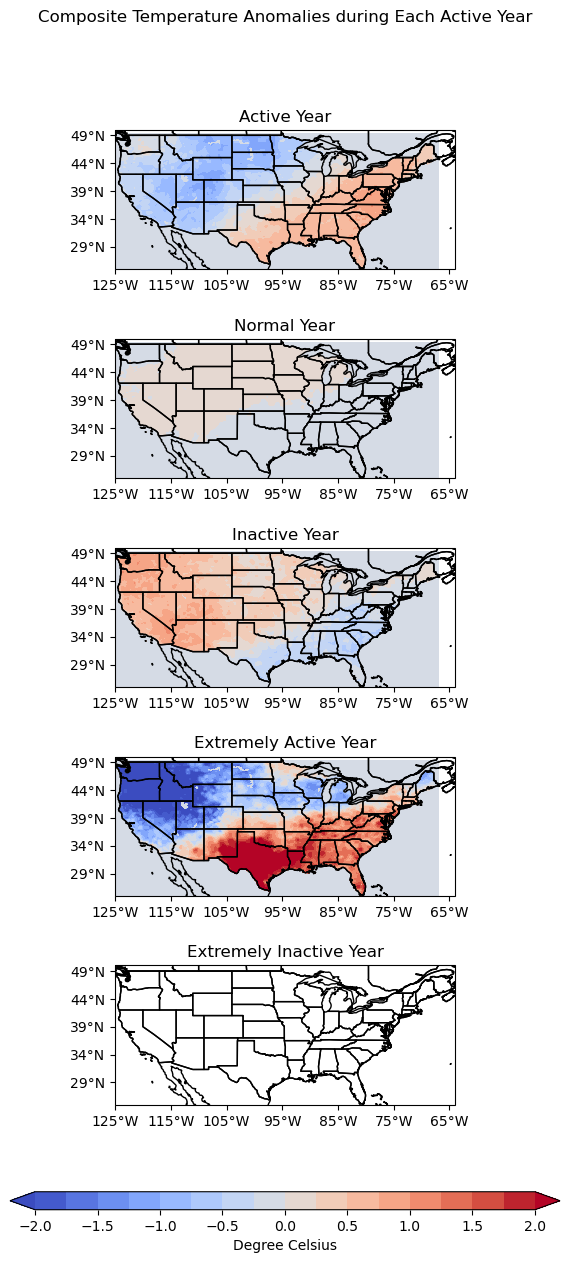

In [103]:
labels = {"Active Year": "Active Year", 
          "Inactive Year": "Inactive Year", 
          "Normal Year":"Normal Year", 
          "Extreme Active Year":"Extremely Active Year", 
          "Extreme Inactive Year": "Extremely Inactive Year"}
clevs =np.arange(-2.0, 2.1, 0.25)

# Define the figure and each axis for the 5 rows and 1 columns
fig, axs = plt.subplots(nrows=5,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,15))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i, activity in enumerate(comp_st):

        # Select the season
        data = comp_st[activity]

        # Contour plot
        cs=axs[i].contourf(comp_st[activity]['lon'],comp_st[activity]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm',extend='both')
        # Longitude labels
        axs[i].set_xticks(np.arange(-125,-60,10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(24,50,5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[activity])
        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].add_feature(feature.BORDERS) #to draw borderline of the US
        axs[i].add_feature(feature.STATES) #to add Stateline 
        axs[i].set_extent([-125, -64, 25, 50], crs=ccrs.PlateCarree())
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Degree Celsius')

# Add a big title at the top
plt.suptitle('Composite Temperature Anomalies during Each Active Year') ;

In [46]:
# we can see that the year with higher number of tornado match with the year with higher surface temperature and vice versa so there might be some relationship here
### we will perform Significant Testing to evaluate - Statistical Significant

In [47]:
# calculate the differences between active/inactive year and the normal year
diff_st = [active_year_st- norm_year_st, 
           inactive_year_st - norm_year_st,
           e_active_year_st - norm_year_st,
           e_inactive_year_st - norm_year_st]

Text(0.5, 0.98, 'Composite Temperature Difference during Each Active Year')

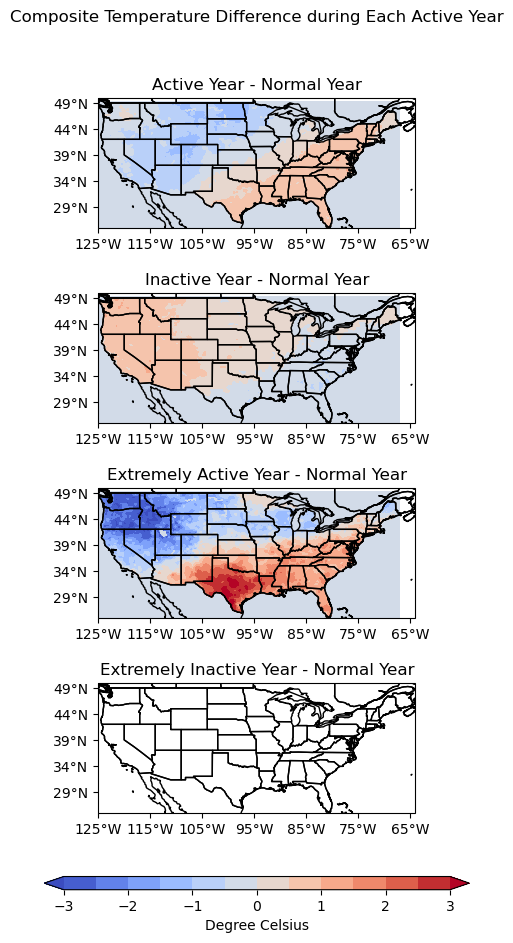

In [104]:
# Now plot our diff maps
labels=['Active Year - Normal Year', 'Inactive Year - Normal Year', 'Extremely Active Year - Normal Year', 'Extremely Inactive Year - Normal Year']
clevs=np.arange(-3,3.5,0.5)
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4,
                        ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))
# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,activity in enumerate(diff_st):

        # Select the season
        data = diff_st[i]


        # Contour plot
        cs = axs[i].contourf(diff_st[i]['lon'],diff_st[i]['lat'],data,clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='coolwarm',extend='both')
        # Longitude labels
        axs[i].set_xticks(np.arange(-125,-60,10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(24,50,5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])
        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].add_feature(feature.BORDERS) #to draw borderline of the US
        axs[i].add_feature(feature.STATES) #to add Stateline 
        axs[i].set_extent([-125, -64, 25, 50], crs=ccrs.PlateCarree())
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Degree Celsius')

# Add a big title at the top
plt.suptitle('Composite Temperature Difference during Each Active Year')

In [49]:
# Calculate Significance Using the built-in Stats Functions - choose p value of 5 %
p = 0.05 # 95% confidence level, or 5% likelihood that the result arose by chance

In [50]:
from scipy.stats import ttest_ind

active_year_st_vals = da_anoms.sel(time=tor_active.dropna(dim='time')['time'])
inactive_year_st_vals = da_anoms.sel(time=tor_inactive.dropna(dim='time')['time'])
norm_precip_vals = da_anoms.sel(time=tor_normal.dropna(dim='time')['time'])
e_active_year_st_vals = da_anoms.sel(time=tor_extreme_active.dropna(dim='time')['time'])
e_inactive_year_st_vals = da_anoms.sel(time=tor_extreme_inactive.dropna(dim='time')['time'])

In [51]:
tstat,pval = ttest_ind(active_year_st_vals, 
                norm_precip_vals, 
                equal_var = False)

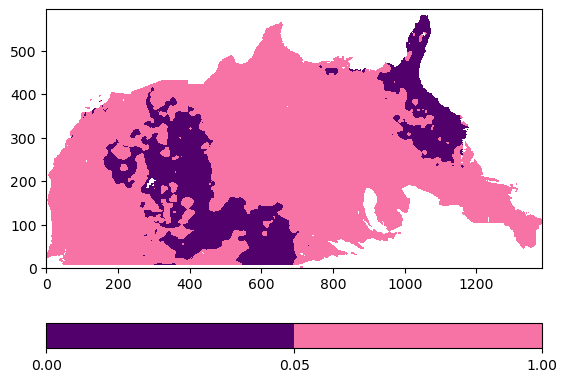

In [52]:
plt.contourf(pval,[0,0.05,1],cmap='RdPu_r') 
plt.colorbar(orientation='horizontal') ;

In [53]:
#Make a mask of where the value is significant

mask_diff = diff_st[0].where(pval <= p)
mask_diff

<xarray.DataArray 'tavg' (lat: 596, lon: 1385)> Size: 3MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02

In [106]:
#Plot our difference between composites and also mark where its significant
labels = ['Active Year vs Normal Year']
clevs=np.arange(-3,3.5,0.5)
hatch_levs=[0]   
          
# Define the figure and each axis for the 1 rows and 1 columns
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()})
data = diff_st[0]
mask_data = mask_diff

          
# Contour plot
cs=axs.contourf(diff_st[0]['lon'],
                diff_st[0]['lat'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='coolwarm',extend='both')
          
# Overlay of stippling
ss=axs.contourf(diff_st[0]['lon'],
                diff_st[0]['lat'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['.',''],extend='both',alpha=0.0)
 # Longitude labels
        axs.set_xticks(np.arange(-125,-60,10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs.xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs.set_yticks(np.arange(24,50,5), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs.yaxis.set_major_formatter(lat_formatter)
# Draw the coastines for each subplot
axs.coastlines()
axs.add_feature(feature.BORDERS) #to draw borderline of the US
axs.add_feature(feature.STATES) #to add Stateline 
axs.set_extent([-125, -64, 25, 50], crs=ccrs.PlateCarree())
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.18, 0.7, 0.025])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Degree Celsius')

# Add a big title at the top
plt.suptitle('Composite Surface Temperature Differences Active Year-Normal Year')


IndentationError: unexpected indent (3289629750.py, line 25)

In [55]:
# surprisingly the significant data are where the surface temperatures are less than normal 
#-> there might not be direct relationship between the higher surface temp and higher number of tornado
# but we can see that colder than norm surface temp does have some significant to the NW be more active 
# for that reason, we can use Correlation to see if there is actually a relationship between surface temp and tornado density

In [56]:
##Correlation 
# recall our Surf Temp anomalies dataset 
da_anoms

<xarray.DataArray 'tavg' (time: 300, lat: 596, lon: 1385)> Size: 991MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02
    month    (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [57]:
#recal Tornado anomalies dataset
tor_anoms

<xarray.Dataset> Size: 12kB
Dimensions:             (time: 300)
Coordinates:
  * time                (time) datetime64[ns] 2kB 2000-01-01 ... 2024-12-01
    month               (time) int64 2kB 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
Data variables:
    State Abbreviation  (time) float64 2kB -23.83 16.44 8.16 ... 5.72 79.28
    Time                (time) float64 2kB -23.83 16.44 8.16 ... 5.72 79.28
    EF Scale            (time) float64 2kB -23.83 16.44 8.16 ... 5.72 79.28

In [63]:
#Pick a point from our Surface Temperature Anomalies - 38.8315° N, 77.3117° W - GMU
pt=da_anoms.sel(lat=38.8315,lon=-77.3117,method='nearest')
pt

<xarray.DataArray 'tavg' (time: 300)> Size: 1kB
array([-7.09101439e-01,  1.42902327e+00,  2.04730463e+00, -1.03953123e+00,
        7.15078115e-01, -2.22812504e-01, -2.81433582e+00, -1.60246098e+00,
       -1.89554691e+00, -1.63359374e-01, -1.92425776e+00, -5.36726570e+00,
       -1.25890613e+00,  8.98749828e-01, -2.33257818e+00, -1.00078128e-01,
       -6.54062510e-01, -3.52695316e-01, -2.79480457e+00,  2.37382814e-01,
       -1.82523441e+00, -8.43046904e-01,  2.36578131e+00,  2.07316399e+00,
        2.66101551e+00,  1.67902327e+00,  1.77187502e-01,  8.80390644e-01,
       -9.94882822e-01,  2.86953121e-01,  2.15937495e-01,  1.02742183e+00,
        1.23984374e-01, -1.12332034e+00, -1.40374994e+00, -2.33699226e+00,
       -3.03917980e+00, -3.51042986e+00, -1.83164060e-01, -1.31003904e+00,
       -2.27417970e+00, -1.95230472e+00, -8.04570317e-01,  2.77421862e-01,
       -6.75820291e-01, -1.90359378e+00,  2.13628912e+00, -1.08699214e+00,
       -3.29894543e+00, -1.46062517e+00,  7.36757815e-01,  5.07812481e-04,
        3.09593749e+00, -1.04312503e+00, -8.14335942e-01, -1.22257817e+00,
       -1.15273438e-01, -9.83671904e-01,  1.06597662e+00, -5.27421892e-01,
        2.41093859e-01, -1.11015767e-01, -2.63238287e+00, -6.59648418e-01,
       -2.78492188e+00,  9.74999964e-02,  2.25703120e-01,  5.37187517e-01,
        1.38472652e+00,  1.56953126e-01,  5.56210935e-01, -2.76765633e+00,
        3.64148426e+00, -3.20976704e-01,  7.75781274e-02,  8.90156269e-01,
       -1.31421876e+00, -4.32773441e-01,  4.75703120e-01,  7.37382829e-01,
...
        1.84468746e+00,  5.26093721e-01, -2.24359369e+00,  3.12421888e-01,
       -2.49140516e-01,  4.99335796e-01, -1.26324224e+00,  1.85011721e+00,
        2.10570312e+00,  9.74999964e-02,  9.45429683e-01,  1.77812502e-01,
        1.99410152e+00,  1.54660153e+00, -2.19378901e+00,  3.23164076e-01,
        2.64148426e+00,  2.24933577e+00,  2.63714838e+00, -1.86960936e+00,
       -1.63453126e+00,  3.67031246e-01,  1.97570312e+00,  5.97734392e-01,
       -1.10550785e+00,  5.86640596e-01,  2.54546881e+00,  2.72382826e-01,
        9.71562624e-01, -1.04070330e+00,  1.63714838e+00,  3.07812504e-02,
       -8.44492197e-01,  4.37343746e-01,  3.25312495e-01,  9.47343767e-01,
        4.54062492e-01,  3.02609372e+00, -1.30414057e+00,  3.28312492e+00,
       -1.73839831e+00,  1.22882795e+00,  1.29730463e+00, -9.49687481e-01,
        3.65468740e-01, -3.52695316e-01,  2.15937495e-01,  4.67851549e-01,
       -6.54687509e-02, -1.74343753e+00,  1.11578131e+00, -9.66875017e-01,
        4.41101551e+00,  3.72882795e+00,  5.37539065e-01,  1.84035158e+00,
       -1.67457032e+00, -1.72281253e+00,  6.15351558e-01, -3.42695326e-01,
        3.64218742e-01,  9.86054659e-01, -7.54335940e-01,  2.03312492e+00,
        1.42078137e+00,  2.36945295e+00,  2.13714838e+00,  1.39992189e+00,
        1.19554687e+00,  1.43734372e+00,  1.42589843e+00,  5.76953143e-02,
       -1.45546868e-01,  4.46015626e-01,  2.18609381e+00, -5.46953142e-01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
    lat      float32 4B 38.81
    lon      float32 4B -77.31
    month    (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

<>:8: SyntaxWarning: invalid escape sequence '\;'
<>:8: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_2545909/90531557.py:8: SyntaxWarning: invalid escape sequence '\;'
  ax1.set_ylabel('Surface Temp. Anomaly [38.81 N,77.31 W]  $mm\;d^{-1}$', color='b')


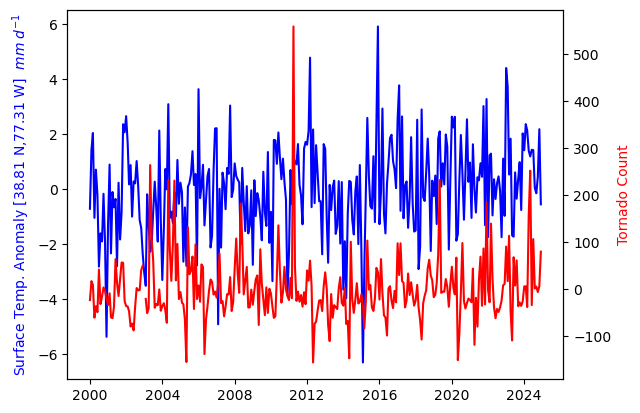

In [64]:
# Plot the Nino34 index and the point together
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(pt['time'],pt,'b')
ax2.plot(tor_anoms['time'],tor_anoms['EF Scale'],'r')

ax1.set_ylabel('Surface Temp. Anomaly [38.81 N,77.31 W]  $mm\;d^{-1}$', color='b')
ax2.set_ylabel('Tornado Count', color='r') ;

In [70]:
# we can kinda see the tornado count went up over time as surface temp anomaly also went up 
# Calculate Correlation over a domain
R = np.corrcoef(tor_anoms['EF Scale'],pt)
R

array([[nan, nan],
       [nan,  1.]])

In [67]:
r_map = xr.corr(tor_anoms['EF Scale'],da_anoms,dim='time')
r_map

<xarray.DataArray (lat: 596, lon: 1385)> Size: 7MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 2kB 49.35 49.31 49.27 49.23 ... 24.65 24.6 24.56
  * lon      (lon) float32 6kB -124.7 -124.6 -124.6 ... -67.1 -67.06 -67.02

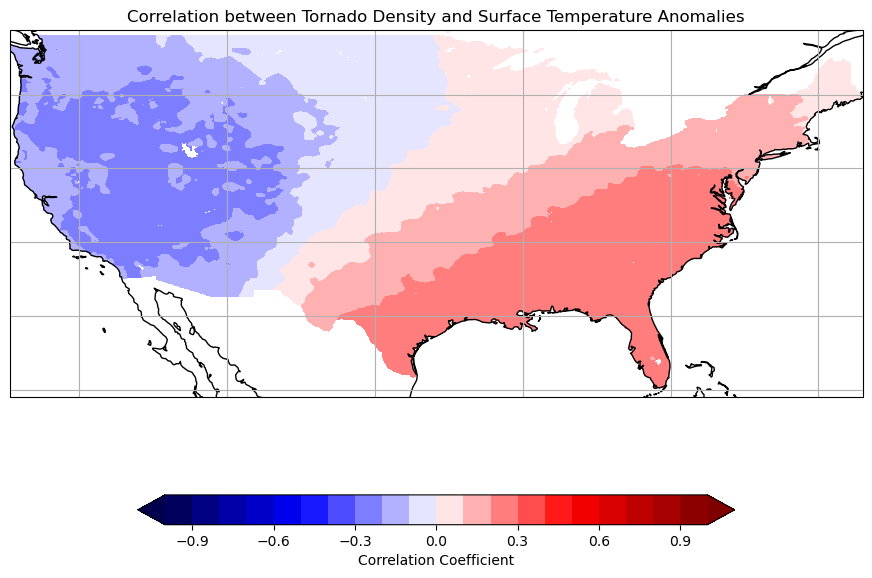

In [69]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

data=r_map
#data,lon=add_cyclic_point(r_map,coord=da_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(da_anoms['lon'],da_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='seismic',extend='both')

# Add coastlines
ax.coastlines()
ax.add_feature(feature.BORDERS) #to draw borderline of the US
ax.add_feature(feature.STATES) #to add Stateline 
ax.set_extent([-125, -64, 25, 50], crs=ccrs.PlateCarree())

# Add gridlines
#ax.gridlines()

#label_latlon(ax,np.arange(-180,181,60),np.arange(-90,91,30))
# Define the xticks for longtitude 
#ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
#lon_formatter=cticker.LongitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
#ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
#lat_formatter=cticker.LatitudeFormatter()
#ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Tornado Density and Surface Temperature Anomalies') ;

In [71]:
#Red areas indicate that the Surface goes up with Tornado count goes up and down when Tornado count goes down.
#Blue area indicate the oppposite: Surface temperature increases when Tornado count decreases and decreases when Tornado count increases.
#The values near zero indicate no relationship between Surface Temp anomalies and Tornado count.